# Analyze predictions

In [2]:
import ast
import matplotlib.pyplot as plt
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from captum.attr import visualization as viz
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [3]:
# convert strings into lists
def literal_eval_column(column):
    try:
        return ast.literal_eval(column)
    except (SyntaxError, ValueError):
        return column

In [8]:
# read distilbert predictions
dist_test = pd.read_csv('outputs/distilbert_attributions.csv')
dist_test = dist_test.applymap(literal_eval_column).drop(columns=['Unnamed: 0', 'index'])

In [9]:
dist_test.head()

,attributions_pred,label_pred,score,tokens,label_gold,correct,sum_attributions_pred,mean_attributions_pred,attributions_gold,sum_attributions_gold,mean_attributions_gold
0,"[-0.011615987537462793, 0.003815996398574733, ...",rec.autos,0.801348,"[i, am, a, little, confused, on, all, of, the,...",rec.autos,True,2.790767,0.025371,"[-0.011615987537462793, 0.003815996398574733, ...",2.790767,0.025371
1,"[-0.32846125995080416, 0.021676696368081335, -...",comp.windows.x,0.915943,"[i, ', m, not, familiar, at, all, with, the, f...",comp.windows.x,True,3.255837,0.018395,"[-0.32846125995080416, 0.021676696368081335, -...",3.255837,0.018395
2,"[-0.014673215540331483, 0.1312478060786364, 0....",alt.atheism,0.072379,"[in, a, word, ,, yes, .]",alt.atheism,True,1.704919,0.284153,"[-0.014673215540331483, 0.1312478060786364, 0....",1.704919,0.284153
3,"[-0.6194980171999851, 0.0018658245313804055, 0...",talk.politics.mideast,0.808439,"[they, were, attacking, the, iraqi, ##s, to, d...",talk.politics.mideast,True,4.223599,0.008282,"[-0.6194980171999851, 0.0018658245313804055, 0...",4.223599,0.008282
4,"[-0.08235069488343288, 0.03930023488145007, -0...",alt.atheism,0.626613,"[i, ', ve, just, spent, two, solid, months, ar...",talk.religion.misc,False,1.368739,0.068437,"[-0.09691212604112631, 0.011566433822874374, -...",1.375414,0.068771


In [10]:
# read SVM predictions
svm_test = pd.read_csv('outputs/coefs_test.csv')
svm_test = svm_test.applymap(literal_eval_column).drop(columns=['Unnamed: 0'])

In [11]:
# exclude erroneous indices
with open('nohup-att-dist4.out', 'r', encoding='utf-8') as f:
    lines = f.readlines()
error_indices = [int(l.split(' ')[0]) for l in lines[7:] if l]

svm_test = svm_test[~svm_test.index.isin(error_indices)]
svm_test = svm_test.reset_index()

In [13]:
svm_test.tail()

,index,true class no,true class name,pred class no,pred class name,feature ind,tfidf,feature names,coef true,coef pred,coef true*tfidf,coef pred*tfidf
7304,7527,14,sci.space,14,sci.space,"[18607, 18295, 18294, 17756, 17294, 17279, 171...","[0.017691756398058683, 0.018650733635436213, 0...","[warm, varies, varied, try, things, thermal, t...","[-0.4585002959556874, -0.4052604615314347, -0....","[-0.4585002959556874, -0.4052604615314347, -0....","[-0.008111675544485832, -0.007558404920996732,...","[-0.008111675544485832, -0.007558404920996732,..."
7305,7528,4,comp.sys.mac.hardware,4,comp.sys.mac.hardware,"[17316, 10666, 9725, 6231, 5108, 1304]","[0.14779138117244353, 0.2403323623065925, 0.20...","[thought, macs, jim, edu, day, actually]","[-0.4994580224796735, -0.15024876263583953, -0...","[-0.4994580224796735, -0.15024876263583953, -0...","[-0.0738155909799283, -0.036109640057913804, -...","[-0.0738155909799283, -0.036109640057913804, -..."
7306,7529,9,rec.sport.baseball,9,rec.sport.baseball,"[18639, 18501, 18373, 17986, 17316, 17294, 156...","[0.020255864930211472, 0.029267291360587883, 0...","[wasn, void, version, understood, thought, thi...","[-0.40429532821330094, -0.3673492016941159, -0...","[-0.40429532821330094, -0.3673492016941159, -0...","[-0.00818935156020414, -0.010751316117061054, ...","[-0.00818935156020414, -0.010751316117061054, ..."
7307,7530,6,misc.forsale,12,sci.electronics,"[18939, 18226, 18177, 18175, 17392, 16625, 166...","[0.01227474898275108, 0.028237249554259176, 0....","[work, uv, used, use, timer, stuff, student, r...","[-0.6091581217981357, -0.4379001261747615, -0....","[-0.31283400980582565, -0.1472211033427624, -0...","[-0.007477263035876224, -0.01236509514263832, ...","[-0.003839958943634, -0.004157119034742961, -0..."
7308,7531,15,soc.religion.christian,15,soc.religion.christian,"[18939, 18428, 18399, 16809, 16395, 15324, 139...","[0.025833554574752265, 0.05359619747264651, 0....","[work, viewpoint, viable, support, start, scri...","[-0.4113355308195925, -0.4774639320789409, -0....","[-0.4113355308195925, -0.4774639320789409, -0....","[-0.010626258883962635, -0.025590251189769198,...","[-0.010626258883962635, -0.025590251189769198,..."


In [14]:
assert len(svm_test) == len(dist_test)

In [15]:
def merge_subwords(tokens, attributions, aggregate='mean'):
    assert len(tokens) == len(attributions)
    # skip merged tokens
    skip_next_iteration = 0
    tokens_merged = []
    attributions_merged = []
    for i, token in enumerate(tokens):
        if skip_next_iteration != 0:
            skip_next_iteration -= 1
            continue
        if token:
            word = token
            attribution = attributions[i]
            # detokenize
                # check whether next token starts with ##
            if i < len(tokens)-1 and tokens[i+1].startswith('##'):
                # check whether further tokens start with ##
                to_merge = tokens[i:]
                count = 1
                iterator = iter(to_merge[1:])
                while True:
                    try:
                        token = next(iterator)
                        if token.startswith("##"):
                            count += 1
                        else:
                            break
                    except StopIteration:
                        break
                to_merge = to_merge[:count]
                j = len(to_merge)
                word = ''.join(tokens[i:i+j]).replace('##', '')
                attr = [attributions[i:i+j]]
                if aggregate == 'mean':
                    attribution = np.mean(attr)
                skip_next_iteration = count-1
        tokens_merged.append(word)
        attributions_merged.append(attribution)
    assert len(tokens_merged) == len(attributions_merged)
    return tokens_merged, attributions_merged

# features (SVM) != tokens (DistilBERT)
def compare_pred(i, print_result=True, mode='correl'):
    row_svm = svm_test.iloc[i]
    row_dist = dist_test.iloc[i]
    # initialize lists for common features and their attribution/coeff values
    feats = []
    val_svm_gold = []
    val_dist_gold = []
    val_svm_pred = []
    val_dist_pred = []
    # merge subwords and aggregate subword attributions
    tokens, attributions_pred = merge_subwords(row_dist.tokens, row_dist['attributions_pred'])
    tokens2, attributions_gold = merge_subwords(row_dist.tokens, row_dist['attributions_gold'])
    assert tokens == tokens2  # just in case
    for k, f in enumerate(row_svm['feature names']):
        if f in tokens:
            feats.append(f)
            val_svm_gold.append(row_svm['coef true*tfidf'][k])
            val_svm_pred.append(row_svm['coef pred*tfidf'][k])
            # feature more than once in sentence
            if tokens.count(f) > 1:
                indices = [j for j, token in enumerate(tokens) if token == f]
                val_dist_gold.append(np.mean([attributions_gold[j] for j in indices]))
                val_dist_pred.append(np.mean([attributions_pred[j] for j in indices]))
            else:
                # feature index in distilbert tokens
                dist_index = tokens.index(f)
                val_dist_gold.append(attributions_gold[dist_index])
                val_dist_pred.append(attributions_pred[dist_index])
        else:
            print(i, f'feature {f} not in token list')
    assert len(feats) == len(val_dist_gold)
    assert len(val_dist_gold) == len(val_dist_pred)
    assert len(val_dist_pred) == len(val_svm_gold)
    assert len(val_svm_gold) == len(val_svm_pred)
    correl_gold = np.corrcoef(val_dist_gold, val_svm_gold)
    correl_pred = np.corrcoef(val_dist_pred, val_svm_pred)
    if print_result:
        print(feats)
        print(correl_gold)
        print(correl_pred)
    if mode == 'correl':  # return correlations information
        return len(feats), len(tokens), correl_gold[0][1], correl_pred[0][1], feats
    elif mode == 'feats':  # return features, coefficients, attributions
        return feats, tokens, val_dist_gold, val_dist_pred, val_svm_gold, val_svm_pred

In [16]:
compare_pred(0)

['year', 'words', 'value', 'usually', 'time', 'tell', 'summer', 'spring', 'se', 'performance', 'models', 'model', 'mid', 'little', 'le', 'heard', 'features', 'far', 'early', 'differences', 'demand', 'curious', 'confused', 'buy', 'book', 'best', '89', '88']
[[ 1.         -0.10922089]
 [-0.10922089  1.        ]]
[[1.         0.08491424]
 [0.08491424 1.        ]]


(28,
 103,
 -0.10922089148550534,
 0.08491423527018695,
 ['year',
  'words',
  'value',
  'usually',
  'time',
  'tell',
  'summer',
  'spring',
  'se',
  'performance',
  'models',
  'model',
  'mid',
  'little',
  'le',
  'heard',
  'features',
  'far',
  'early',
  'differences',
  'demand',
  'curious',
  'confused',
  'buy',
  'book',
  'best',
  '89',
  '88'])

In [30]:
len([compare_pred(0, print_result=False)])

1

In [35]:
correls = pd.DataFrame(columns=['num_feats', 'num_tokens', 'correl_gold', 'correl_pred', 'features'])

num_instances = len(svm_test)

for i in range(num_instances):
    correls.loc[len(correls)] = list(compare_pred(i, print_result=False))

c:\Users\lydia\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\lydia\anaconda3\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\lydia\anaconda3\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\lydia\anaconda3\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\lydia\anaconda3\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\lydia\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\lydia\anaconda3\lib\site-packages\numpy\core\_methods.py:182: Ru

396 feature haven not in token list


c:\Users\lydia\anaconda3\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\lydia\anaconda3\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\lydia\anaconda3\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\lydia\anaconda3\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\lydia\anaconda3\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\lydia\anaconda3\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\lydia\anaconda3\lib\sit

In [55]:
correls.sort_values(by='correl_gold').head(n=50)

,num_feats,num_tokens,correl_gold,correl_pred,features
5340,2,4,-1.000000,-1.000000,"[simple, eh]"
6923,2,11,-1.000000,-1.000000,"[tesla, discussion]"
6876,2,4,-1.000000,1.000000,"[lou, gehrig]"
100,2,21,-1.000000,1.000000,"[ca, 1993apr21]"
6633,2,12,-1.000000,1.000000,"[really, 10]"
7148,2,14,-1.000000,1.000000,"[os, compared]"
5916,2,13,-1.000000,1.000000,"[dear, come]"
5737,2,7,-1.000000,-1.000000,"[sub, says]"
5510,2,6,-1.000000,-1.000000,"[urban, areas]"
5415,2,11,-1.000000,-1.000000,"[joe, agree]"


In [48]:
correls.sort_values(by='correl_gold', ascending=False).head()

,num_feats,num_tokens,correl_gold,correl_pred,features
751,2,6,1.0,1.0,"[getting, close]"
1147,2,6,1.0,-1.0,"[religion, alt]"
1303,2,10,1.0,-1.0,"[thing, heater]"
6614,2,14,1.0,1.0,"[let, clarify]"
5498,2,11,1.0,-1.0,"[okay, forgot]"


In [49]:
correls.sort_values(by='correl_pred').head()

,num_feats,num_tokens,correl_gold,correl_pred,features
489,2,6,1.0,-1.0,"[stuff, deleted]"
1303,2,10,1.0,-1.0,"[thing, heater]"
3127,2,7,1.0,-1.0,"[compuserve, com]"
3609,2,9,1.0,-1.0,"[reversed, got]"
782,2,13,1.0,-1.0,"[non, cold]"


In [50]:
correls.sort_values(by='correl_pred', ascending=False).head()

,num_feats,num_tokens,correl_gold,correl_pred,features
6633,2,12,-1.0,1.0,"[really, 10]"
1848,2,7,1.0,1.0,"[project, arizona]"
4000,2,7,-1.0,1.0,"[posted, ok]"
3338,2,6,-1.0,1.0,"[suggest, change]"
6264,2,11,1.0,1.0,"[trusted, tools]"


-> highest and lowest correlations for fewest features / shortest sentences!

In [36]:
correls.head()

,num_feats,num_tokens,correl_gold,correl_pred,features
0,28,103,-0.109221,0.084914,"[year, words, value, usually, time, tell, summ..."
1,28,166,0.106889,0.041291,"[view, ve, uncompressed, swamped, send, seeing..."
2,2,6,1.000000,-1.000000,"[yes, word]"
3,120,478,0.022760,0.126682,"[york, world, women, west, want, ve, times, ti..."
4,9,20,0.732862,0.428710,"[ve, thing, spent, solid, objective, moral, mo..."


In [37]:
# slightly higher correlation of gold class attributions/coefficients
np.mean(correls.correl_gold), np.mean(correls.correl_pred)

(0.2826740357767589, 0.25590147310534667)

In [38]:
# correlations not related to numbers of features or tokens in a sentence
correls.corr()

,num_feats,num_tokens,correl_gold,correl_pred
num_feats,1.000000,0.944143,-0.017452,0.023974
num_tokens,0.944143,1.000000,-0.039823,0.004972
correl_gold,-0.017452,-0.039823,1.000000,0.620412
correl_pred,0.023974,0.004972,0.620412,1.000000


In [ ]:
correls.to_csv('outputs/predictions-correlations.csv')

In [36]:
# do some nice visualizations
def barplot(feats, coeffs, attributions, i):
    
    # Define the x-axis positions for the tokens
    y = np.arange(len(feats))

    # Create the barplot
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.barh(y - 0.175, coeffs, label='SVM coefficients', color='blue', alpha=0.7, height=0.35)
    plt.barh(y + 0.175, attributions, label='DistilBERT attributions', color='red', alpha=0.7, height=0.35)

    # Add labels and title
    plt.ylabel('Tokens')
    plt.xlabel('Attributions and Coefficients')
    plt.title('Attributions Comparison')
    plt.yticks(y, feats)  # Set token labels on the x-axis
    plt.legend()  # Show the legend
    plt.savefig(f'outputs/viz/instance_{i}.png', bbox_inches='tight')

def plot(i):
    feats, tokens, val_dist_gold, val_dist_pred, val_svm_gold, val_svm_pred = \
        compare_pred(i, print_result=False, mode='feats')
    print(feats, val_svm_gold, val_dist_gold)
    barplot(feats, val_svm_gold, val_dist_gold, i)

['ve', 'thing', 'spent', 'solid', 'objective', 'moral', 'months', 'exists', 'arguing'] [-0.031128538173265812, -0.0453911111205724, -0.049867347238664574, -0.05671233383941306, -0.02992969593069396, -0.02513820847019012, -0.04632030649892373, -0.04141320116073546, -0.04600534451152419] [-0.004419299194421766, 0.04197022454719444, -0.13133029535882443, -0.17635902812562063, 0.24776842802439084, 0.8522974089407261, -0.11847112311968727, 0.06418855181335427, 0.28709269609495724]


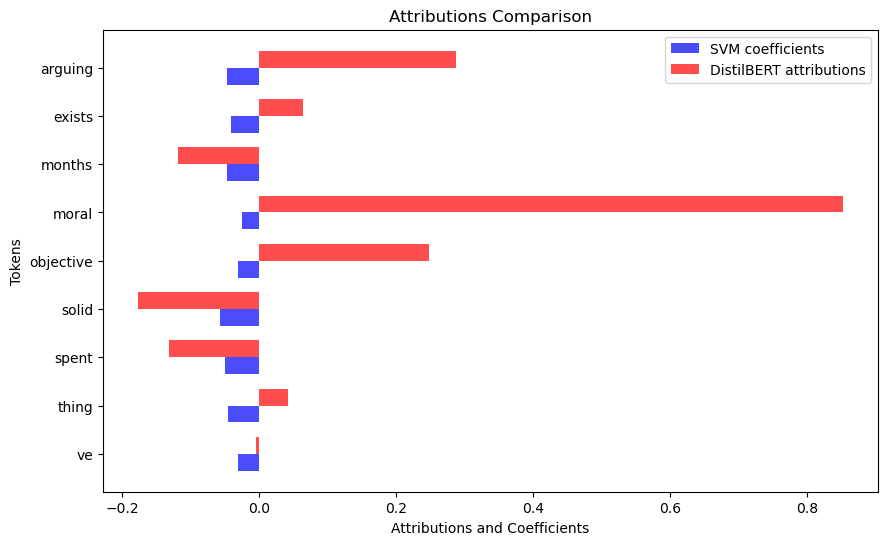

In [37]:
plot(4)

In [40]:
type(svm_test['pred class name'][0]), type(dist_test['label_pred'][0])

(str, str)

In [42]:
label2id = {
    "alt.atheism": 0,
    "comp.graphics": 1,
    "comp.os.ms-windows.misc": 2,
    "comp.sys.ibm.pc.hardware": 3,
    "comp.sys.mac.hardware": 4,
    "comp.windows.x": 5,
    "misc.forsale": 6,
    "rec.autos": 7,
    "rec.motorcycles": 8,
    "rec.sport.baseball": 9,
    "rec.sport.hockey": 10,
    "sci.crypt": 11,
    "sci.electronics": 12,
    "sci.med": 13,
    "sci.space": 14,
    "soc.religion.christian": 15,
    "talk.politics.guns": 16,
    "talk.politics.mideast": 17,
    "talk.politics.misc": 18,
    "talk.religion.misc": 19
  }

In [43]:
dist_label_pred = [label2id[l] for l in dist_test['label_pred']]

In [44]:
# correlations
# compare predicted labels, have to ignore nan values with ma
np.corrcoef(np.ma.masked_invalid(svm_test['pred class no']),
            np.ma.masked_invalid(dist_label_pred))

array([[1.        , 0.71812724],
       [0.71812724, 1.        ]])